In [38]:
import pandas as pd
import sklearn as skl
from sklearn import *
%matplotlib inline
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np

In [278]:
pd.set_option('max_columns', 30)
fulldata1 = pd.read_csv('data.csv');
fulldata1.head(4)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4


In [279]:
fulldata = fulldata1.copy()
fulldata['matchup'] = fulldata['matchup'].map(lambda x: x.split()[1])
fulldata.drop(['game_event_id', 'game_id', 'lat', 'lon', 'team_id', 'team_name', 'shot_id', 'game_date'], axis=1, inplace=True)

actiontypes = dict(fulldata.action_type.value_counts())
fulldata['type'] = fulldata.apply(lambda row: row['action_type'] if actiontypes[row['action_type']] > 20\
                          else row['combined_shot_type'], axis=1)

fulldata.drop(['action_type', 'combined_shot_type'], axis=1, inplace=True)

fulldata['time_remaining'] = fulldata.apply(lambda row: row['minutes_remaining'] * 60 + row['seconds_remaining'], axis=1)
fulldata['last_moments'] = fulldata.apply(lambda row: 1 if row['time_remaining'] < 3 else 0, axis=1)
fulldata['distance'] = fulldata.apply(lambda row: row['shot_distance'] if row['shot_distance'] <45 else 45, axis=1)

text_columns = ['type', 'season', 'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'matchup', 'opponent'] # 'action_type', 'combined_shot_type' , 'game_date'
# get_dummies could be used istead of this code:
for col in text_columns:
    uniq_words = fulldata[col].unique()
    uniq_words = dict(enumerate(uniq_words, 1)) # 1 to enumerate from 1
    uniq_words = {v:k for k,v in uniq_words.items()}
    fulldata = fulldata.replace({col: uniq_words})
fulldata.head(4)

,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,game_date,matchup,opponent,type,time_remaining,last_moments,distance
0,167,72,10,1,0,1,27,18,NaN,1,1,1,1,2000-10-31,1,1,1,627,0,18
1,-157,0,10,1,0,1,22,15,0.0,1,2,1,2,2000-10-31,1,1,1,622,0,15
2,-101,135,7,1,0,1,45,16,1.0,1,3,1,1,2000-10-31,1,1,1,465,0,16
3,138,175,6,1,0,1,52,22,0.0,1,4,1,1,2000-10-31,1,1,1,412,0,22


In [293]:
data_test = fulldata[pd.isnull(fulldata['shot_made_flag'])]
data = fulldata[pd.notnull(fulldata['shot_made_flag'])]
data.head(4)

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f0efcd755c0>>
Traceback (most recent call last):
  File "/home/stas/anaconda3/lib/python3.5/site-packages/xgboost/core.py", line 324, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError: 'DMatrix' object has no attribute 'handle'
Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f0efcd75940>>
Traceback (most recent call last):
  File "/home/stas/anaconda3/lib/python3.5/site-packages/xgboost/core.py", line 324, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError: 'DMatrix' object has no attribute 'handle'


,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,matchup,opponent,type,time_remaining,last_moments,distance
1,-157,0,10,1,0,1,22,15,0.0,1,2,1,2,1,1,1,622,0,15
2,-101,135,7,1,0,1,45,16,1.0,1,3,1,1,1,1,1,465,0,16
3,138,175,6,1,0,1,52,22,0.0,1,4,1,1,1,1,1,412,0,22
4,0,0,6,2,0,1,19,0,1.0,1,5,2,3,1,1,2,379,0,0


In [294]:
dTrain, dTest, YTrain, YTest = model_selection.train_test_split(
                                data.ix[:, data.columns!='shot_made_flag'],
                                data['shot_made_flag'], test_size=0.3, random_state=1)
# dTrain.drop('shot_id', axis=1, inplace=True)
# dTest.drop('shot_id', axis=1, inplace=True)

In [295]:
r_X, r_Y = data.ix[:, data.columns!='shot_made_flag'],  data['shot_made_flag']
# r_X.drop('shot_id', axis=1, inplace=True)

In [307]:
XGBoost = xgb.XGBClassifier(max_depth=7, learning_rate=0.012, n_estimators=1000, subsample=0.62, colsample_bytree=0.6, seed=1)
# xgbRegr = xgb.XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=400) #best

In [308]:
XGBoost.fit(dTrain, YTrain)
# XGBoost.fit(r_X, r_Y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0, learning_rate=0.012, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1, silent=True, subsample=0.62)

In [309]:
aucXGBTrain = metrics.roc_auc_score(YTrain, XGBoost.predict_proba(dTrain)[:,1])
aucXGBTest = metrics.roc_auc_score(YTest, XGBoost.predict_proba(dTest)[:,1])
print('XGBoost:       {:6.4}  {:6.4}'.format(aucXGBTrain, aucXGBTest))
# 0.7072

XGBoost:       0.8947  0.7038


In [239]:
# r_test_acc = xgbRegr.predict(data_test.ix[:, data_test.columns!='shot_made_flag'])
# r_res = list(zip(indices, r_test_acc))
# for z in r_res[:3]:
#     print(z)

In [302]:
indices = [x+1 for x in data_test.index]
test_acc = XGBoost.predict_proba(data_test.ix[:, data_test.columns!='shot_made_flag'])[:,1]
res = list(zip(indices, test_acc))
for z in res[:5]:
    print(z)
with open('result_classiffier.csv', 'w') as f:
    f.write('shot_id,shot_made_flag\n')
    for s,m in res:
        f.write(str(s) + ',' +str(m)+'\n')

(1, 0.36732525)
(8, 0.38175383)
(17, 0.65039819)
(20, 0.75877267)
(33, 0.32305139)


In [77]:
# with open('result_regressor.csv', 'w') as f:
#     f.write('shot_id,shot_made_flag\n')
#     for s,m in r_res:
#         f.write(str(s) + ',' +str(m)+'\n')

In [14]:
def fit_and_test_classifier(classifier):
    classifier.fit(dTrain, YTrain)
    aucXGBTrain = metrics.roc_auc_score(YTrain, classifier.predict_proba(dTrain)[:,1])
    aucXGBTest = metrics.roc_auc_score(YTest, classifier.predict_proba(dTest)[:,1])
    print('XGBoost:       {:6.4}  {:6.4}'.format(aucXGBTrain, aucXGBTest))

In [179]:
# depths = [2,3,4]
# lrs = [0.5, 0.1, 0.01]
# n_ests = [50,100,200]
# for d in depths:
#     for lr in lrs:
#         for e in n_ests:
#             c = xgb.XGBClassifier(max_depth=d, learning_rate=lr, n_estimators=e)
#             print('depth: {0}, lr: {1}, n_estiminators: {2}'.format(d, lr, e))
#             fit_and_test_classifier(c)

In [181]:
# c = xgb.XGBClassifier(max_depth=7, learning_rate=0.012, n_estimators=1000, subsample=0.62, colsample_bytree=0.6, seed=1)
# fit_and_test_classifier(c)

In [200]:
XGBoost.feature_importances_
# 7057

array([ 0.08154062,  0.0251117 ,  0.11823598,  0.10632136,  0.0259391 ,
        0.03309615,  0.00256495,  0.06292404,  0.08323681,  0.06735066,
        0.00091014,  0.01187324,  0.00885322,  0.00777759,  0.13246731,
        0.02035413,  0.08766341,  0.1220834 ,  0.00169618], dtype=float32)

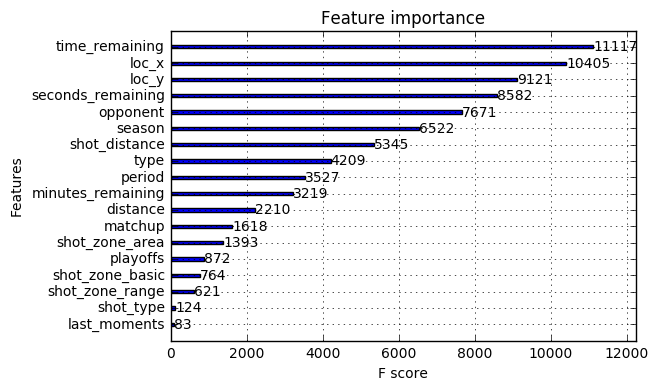

In [311]:
xgb.plot_importance(XGBoost)

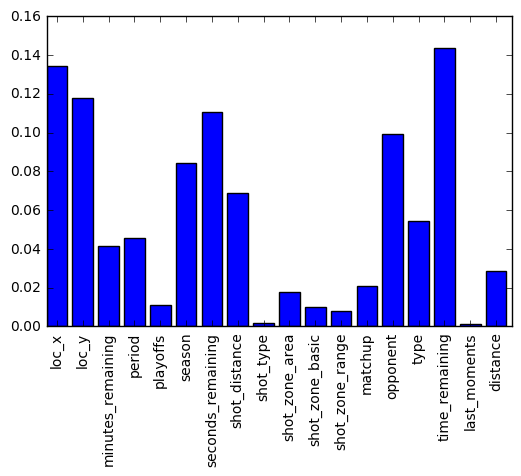

In [312]:
labels = dTrain.columns
cols = list(labels)
plt.bar(range(len(XGBoost.feature_importances_)), XGBoost.feature_importances_)
plt.xticks(np.arange(len(cols)) + 0.4, labels, rotation='vertical')
plt.show()

In [193]:
r_X.columns

Index(['action_type', 'combined_shot_type', 'loc_x', 'loc_y',
       'minutes_remaining', 'period', 'playoffs', 'season',
       'seconds_remaining', 'shot_distance', 'shot_type', 'shot_zone_area',
       'shot_zone_basic', 'shot_zone_range', 'game_date', 'matchup',
       'opponent', 'shot_id', 'time_remaining', 'last_moments'],
      dtype='object')